In [1]:
import tensorflow as tf

# List all physical devices
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # Get the virtual device configuration for each GPU
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error fetching virtual devices for {gpu}: {e}")


In [7]:
import os
import sys
import tensorflow as tf
sys.path.append("C:/Users/mattj/zoobot")
from zoobot.data_utils import tfrecord_datasets
from zoobot.estimators import auto_preprocess as preprocess
from zoobot import schemas, label_metadata
import logging
import pandas as pd
from galaxyvaev2 import model
import time

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from zoobot import label_metadata, schemas
from zoobot.data_utils import image_datasets
from zoobot.estimators import preprocess

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [8]:
decals_test = pd.read_csv('../../../Ilifu_data/decals_ilifu_test.csv')

In [9]:
test_paths = decals_test['file_loc'].to_numpy()

In [10]:
file_format = 'png'
initial_size = 224
batch_size = 64
raw_image_ds = image_datasets.get_image_dataset([str(x) for x in test_paths], file_format, initial_size, batch_size)

preprocessing_config = preprocess.PreprocessingConfig(
    label_cols=[],
    input_size=initial_size,
    make_greyscale=False,
    normalise_from_uint8=True
)

image_ds = preprocess.preprocess_dataset(raw_image_ds, preprocessing_config)

INFO:root:Images to predict on: 49917


In [11]:
question_answer_pairs = label_metadata.decals_pairs
dependencies = label_metadata.get_gz2_and_decals_dependencies(question_answer_pairs)
schema = schemas.Schema(question_answer_pairs, dependencies)

batch_size = 64
train_records_dir = "D:/lengau_auto_shards/train_shards"
eval_records_dir = "D:/lengau_auto_shards/eval_shards"

train_records = [os.path.join(train_records_dir, x) for x in os.listdir(train_records_dir) if x.endswith('.tfrecord')]
eval_records = [os.path.join(eval_records_dir, x) for x in os.listdir(eval_records_dir) if x.endswith('.tfrecord')]

raw_train_dataset = tfrecord_datasets.get_dataset(train_records, schema.label_cols, batch_size, shuffle=True)
raw_test_dataset = tfrecord_datasets.get_dataset(eval_records, schema.label_cols, batch_size, shuffle=False)

preprocess_config = preprocess.PreprocessingConfig(
    label_cols=schema.label_cols,
    input_size=224,
    make_greyscale=False,
    normalise_from_uint8=True
)

train_dataset = preprocess.preprocess_dataset(raw_train_dataset, preprocess_config)
test_dataset = preprocess.preprocess_dataset(raw_test_dataset, preprocess_config)

input_shape=(224,224,3)
latent_dim=64

vae_model,decoder_model,encoder_model=model(input_shape,latent_dim)

vae_model.compile(optimizer=tf.keras.optimizers.Adam())
# start = time.time()
vae_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir="D:/logs")]
)

vae_model.save("model_save3")
vae_model.save("model_save3.h5")

INFO:root:Q/A pairs: {'smooth-or-featured': ['_smooth', '_featured-or-disk', '_artifact'], 'disk-edge-on': ['_yes', '_no'], 'has-spiral-arms': ['_yes', '_no'], 'bar': ['_strong', '_weak', '_no'], 'bulge-size': ['_dominant', '_large', '_moderate', '_small', '_none'], 'how-rounded': ['_round', '_in-between', '_cigar-shaped'], 'edge-on-bulge': ['_boxy', '_none', '_rounded'], 'spiral-winding': ['_tight', '_medium', '_loose'], 'spiral-arm-count': ['_1', '_2', '_3', '_4', '_more-than-4', '_cant-tell'], 'merging': ['_none', '_minor-disturbance', '_major-disturbance', '_merger']}
INFO:root:tfrecord.io: Loading dataset from ['D:/lengau_auto_shards/train_shards\\s224_shard_0.tfrecord', 'D:/lengau_auto_shards/train_shards\\s224_shard_1.tfrecord', 'D:/lengau_auto_shards/train_shards\\s224_shard_10.tfrecord', 'D:/lengau_auto_shards/train_shards\\s224_shard_11.tfrecord', 'D:/lengau_auto_shards/train_shards\\s224_shard_12.tfrecord', 'D:/lengau_auto_shards/train_shards\\s224_shard_13.tfrecord', 'D:/le

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}
Epoch 1/10
3120/3120 [==============================] - 1365s 427ms/step - loss: 45362.6094 - reconstruction_loss: 45257.3633 - kl_loss: 105.2787 - elbo_loss: 45362.6094 - val_loss: 44168.4219 - val_reconstruction_los

INFO:tensorflow:Assets written to: model_save3\assets


INFO:tensorflow:Assets written to: model_save3\assets


In [12]:
encoder_model.save("encoder_model2.h5")
decoder_model.save("decoder_model2.h5")
encoder_model.save("encoder_model2")
decoder_model.save("decoder_model2")

INFO:tensorflow:Assets written to: encoder_model2\assets


INFO:tensorflow:Assets written to: encoder_model2\assets


INFO:tensorflow:Assets written to: decoder_model2\assets


INFO:tensorflow:Assets written to: decoder_model2\assets


In [13]:
# import matplotlib.pyplot as plt

# # Plot reconstruction and KL loss over epochs
# # plt.plot(vae_model.history['reconstruction_loss'], label='Reconstruction Loss')
# plt.plot(vae_model.history['kl_loss'], label='KL Divergence Loss')
# plt.plot(vae_model.history['total_loss'], label='Total Loss (ELBO)')
# plt.legend()
# plt.title('VAE Losses Over Time')
# plt.xlabel('Epochs')
# # plt.ylabel('Loss')
# plt.show()

# print(vae_model)

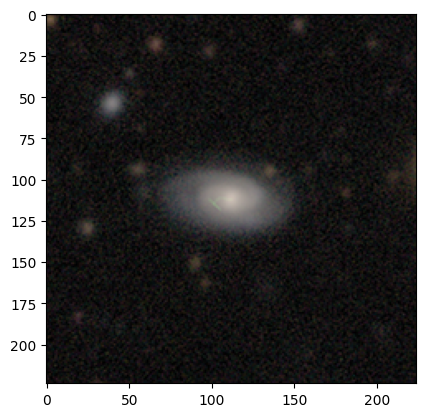

In [14]:
for element in image_ds:
    for image in element[0]:
        img = np.array(image)
    break

plt.imshow(img)
plt.show()

In [2]:
# vae_model = tf.keras.models.load_model("model_save3.h5")

In [10]:
vae_model.get_layer("model_3").summary()
vae_model.get_layer("model_4").summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 112, 112, 8)  608         ['input_3[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 56, 56, 16)   1168        ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 32)   4640        ['conv2d_4[0][0]']         

In [17]:
test = np.array([img])
output = vae_model.predict(test)

1/1 [==============================] - 1s 1s/step


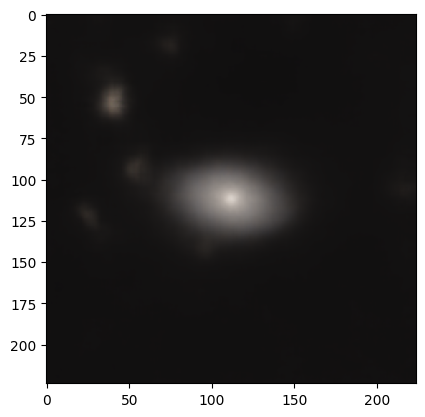

In [18]:
plt.imshow(output[0])
plt.show()

In [19]:
output.shape

(1, 224, 224, 3)

In [20]:
mean, var = encoder_model.predict(image_ds)


780/780 [==============================] - 1016s 1s/step


In [21]:
mean.shape

(49917, 64)

In [22]:
decals_test['file_loc']

0        D:/GZD_data/dr5/J080/J080814.29+065011.3.png
1        D:/GZD_data/dr5/J084/J084657.83+180645.8.png
2        D:/GZD_data/dr5/J121/J121527.84+034006.9.png
3        D:/GZD_data/dr5/J152/J152034.19+280420.5.png
4        D:/GZD_data/dr5/J135/J135405.57+090342.3.png
                             ...                     
49912    D:/GZD_data/dr5/J133/J133534.80+074614.5.png
49913    D:/GZD_data/dr5/J083/J083254.18+142328.5.png
49914    D:/GZD_data/dr5/J101/J101300.94+173152.5.png
49915    D:/GZD_data/dr5/J133/J133710.73+014555.0.png
49916    D:/GZD_data/dr5/J102/J102114.32+041609.5.png
Name: file_loc, Length: 49917, dtype: object

In [23]:
auto_df = pd.DataFrame(mean)

In [24]:
final_features = pd.DataFrame(decals_test['file_loc'])
final_features = final_features.join(auto_df)

In [25]:
final_features

,file_loc,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,D:/GZD_data/dr5/J080/J080814.29+065011.3.png,-0.669056,0.338567,-1.167145,1.571515,-0.066392,0.047658,-0.784699,-1.226872,-0.908602,...,1.267466,0.121482,0.279857,0.474918,0.096191,1.127401,0.615469,-0.281024,-0.780872,0.613950
1,D:/GZD_data/dr5/J084/J084657.83+180645.8.png,0.643919,0.660835,-1.484921,0.952403,0.527761,-0.345933,-0.266018,-0.048301,0.565976,...,-0.428478,0.408268,0.924553,-0.616144,2.290006,-0.691402,0.348773,-0.045943,-0.412501,-0.792864
2,D:/GZD_data/dr5/J121/J121527.84+034006.9.png,0.395103,0.424369,0.494721,0.351704,-0.474364,0.010701,0.159801,0.321116,-0.100323,...,-0.126900,-0.012483,-0.149447,0.386919,0.199213,0.629876,0.114862,0.527226,-0.718948,-0.195773
3,D:/GZD_data/dr5/J152/J152034.19+280420.5.png,1.435601,-0.157963,-2.165187,0.548370,-0.653388,-0.207814,0.324550,-0.633190,3.382944,...,0.469510,0.106716,1.063029,0.992685,-0.597540,-0.421279,0.293565,-0.314396,0.308515,-0.379550
4,D:/GZD_data/dr5/J135/J135405.57+090342.3.png,-0.668241,1.944722,-0.279894,0.542740,-0.425260,0.195171,-1.648234,0.056621,-0.750553,...,-0.112262,0.298591,0.934150,1.015554,-0.923999,-0.040946,0.256224,0.065081,-0.156090,0.445426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49912,D:/GZD_data/dr5/J133/J133534.80+074614.5.png,0.307505,0.477969,0.636442,0.316622,-0.814710,0.072737,0.278178,-0.304004,0.706377,...,0.010606,-0.098755,0.093450,-0.014370,0.037444,0.540602,0.184092,-0.205694,0.145052,0.320849
49913,D:/GZD_data/dr5/J083/J083254.18+142328.5.png,0.027257,0.900343,0.958823,0.663420,-0.742178,-1.182704,0.266170,-1.402780,1.711055,...,-0.006704,-0.116824,-0.628403,2.695590,0.728128,1.196388,-0.293398,1.730328,0.028994,0.106361
49914,D:/GZD_data/dr5/J101/J101300.94+173152.5.png,-0.282596,-0.034800,-0.236270,0.145716,0.124144,0.120566,-0.327131,-0.850911,0.124990,...,-0.210762,0.679396,0.292094,1.172004,0.459311,-0.559752,-0.507083,-0.674706,-0.386490,-0.923078
49915,D:/GZD_data/dr5/J133/J133710.73+014555.0.png,0.319035,0.240219,-0.798127,0.035140,-0.040294,0.723950,-0.203588,0.274719,-0.279155,...,-0.779727,0.044738,0.614937,0.781158,0.476153,0.221296,0.938254,0.563551,-0.553096,1.876662


In [26]:
final_features.to_csv("../autoencoder/extracted_features_vaev2.csv", index=False)